In [37]:
import json
import matplotlib.pyplot as plt
import numpy as np

In [38]:
###################################################
###         read all data form log-file         ###
###################################################

file_data = 'C:\\Users\Jan\GitRepos\data\Sud1.json'

time=[]
airflow=[]
with open (file_data) as f:
    i=0
    for line in f:
        i += 1
        if i <= 38643:                            #  skip first lines (fermentation did not start there)
            continue

        fermentation = json.loads(line)
        time.append(fermentation['Timestamp'])
        airflow_dict = fermentation['airflow']
        airflow.append(airflow_dict['flow'])



In [39]:
###########################################################
###         transform data into numpy arrays            ###
###########################################################

time = np.array(time)
time -= 1620165728601                               # first timestamp should be zero

airflow = np.array(airflow)
airflow = airflow.clip(min=0)                       # set negativ values to zero

print('time shape:', time.shape)
print('airflow shape:', airflow.shape)

time shape: (231709,)
airflow shape: (231709,)


In [40]:
##################################################################
###         set small values after fermantaion to zero         ###
##################################################################

airflow[114204:] = 0
print(airflow[114203])
print(airflow[114204])
print(airflow[114205])

40.70435
0.0
0.0


In [41]:
##############################################################################
###         calculations with arrays to create more detailed data          ###
##############################################################################

time_days = np.multiply(1.157416667e-8, time).round(decimals=7)
time_seconds = np.multiply(0.001, time).round(decimals=0)

print('time_days:', time_days[:4])
print('time_seconds:', time_seconds[:4], '\n')

# ----------------------------------------------------------------

airflow = airflow.round(decimals=4)
airflow_5s = np.multiply(0.0833333333333, airflow).round(decimals=2)        # multiply with (5/60) --> Standart Liter per 5 secondes [SL/5s]
airflow_sum = np.cumsum(airflow_5s)                                         # sum up all values of airflow_5s in airflow_sum [l] --> total number of liters

print('airflow:', airflow[:3])
print('airflow_5s:', airflow_5s[:3])
print('airflow_sum:', airflow_sum[:3], '\n')

print('airflow:', airflow[65000:65003])
print('airflow_5s:', airflow_5s[65000:65003])
print('airflow_sum:', airflow_sum[65000:65003])

time_days: [0.000e+00 5.800e-05 1.160e-04 1.738e-04]
time_seconds: [ 0.  5. 10. 15.] 

airflow: [0. 0. 0.]
airflow_5s: [0. 0. 0.]
airflow_sum: [0. 0. 0.] 

airflow: [62.0972 64.7675 63.6536]
airflow_5s: [5.17 5.4  5.3 ]
airflow_sum: [137725.17 137730.57 137735.87]


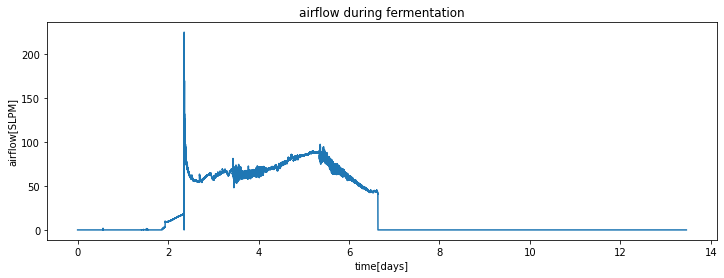

In [42]:
plt.figure(figsize=(12,4))
plt.title('airflow during fermentation')
plt.plot(time_days,airflow)
plt.xlabel('time[days]')
plt.ylabel('airflow[SLPM]')
plt.show()

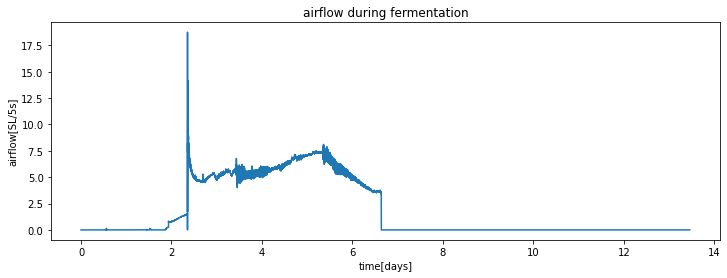

In [43]:
plt.figure(figsize=(12,4))
plt.title('airflow during fermentation')
plt.plot(time_days,airflow_5s)
plt.xlabel('time[days]')
plt.ylabel('airflow[SL/5s]')
plt.show()

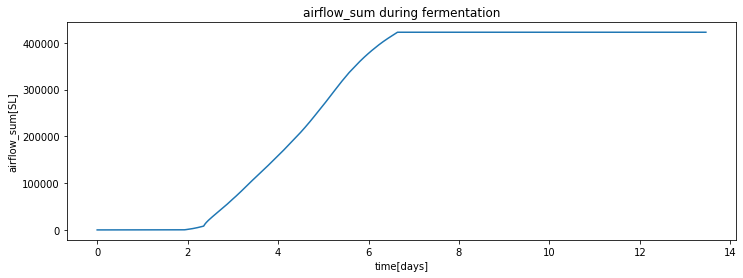

In [44]:
plt.figure(figsize=(12,4))
plt.title('airflow_sum during fermentation')
plt.plot(time_days,airflow_sum)
plt.xlabel('time[days]')
plt.ylabel('airflow_sum[SL]')
plt.show()

In [45]:
##############################################
###         !!! Kontrollrechnung !!!       ###
##############################################

# Wir haben ca. 250 kg Extrakt
Extrakt = 250

# Etwa 2/3 des Extrakts vergären
vergoren = Extrakt * 0.66

# vergorener Exktrakt wird zu 46,3% zu CO2
CO2 = vergoren * 0.463

# 15% des CO2 bleiben im Bier gebunden
CO2_air = CO2 * 0.85

# 1 Liter CO2 wiegt 1,96g
# --> 1kg CO2 entsprechen ca. 510 Liter
CO2_volume = CO2_air * 510

# 1000 Liter Platz im Tank
CO2_volume_outside = CO2_volume - 1000


print('vergorener Extrakt:', vergoren, 'kg')
print('CO2 Masse gesamt:', CO2, 'kg')
print('CO2 Masse NICHT im Bier gebunden:', CO2_air, 'kg')
print('CO2 Volumen:', CO2_volume, 'Liter')
print('CO2 Volumen durch den Sensor:', CO2_volume_outside, 'Liter\n')

print('Aus dem Tank ausgeströmter CO2:', airflow_sum[-1], 'Liter')

vergorener Extrakt: 165.0 kg
CO2 Masse gesamt: 76.39500000000001 kg
CO2 Masse NICHT im Bier gelöst: 64.93575000000001 kg
CO2 Volumen: 33117.232500000006 Liter
CO2 Volumen durch den Sensor: 32117.232500000006 Liter

Aus dem Tank ausgeströmter CO2: 422689.9900000109 Liter


In [46]:
###########################################
###         Extraktberechnung           ###
###########################################


# ----------------------------------------------------------------
#           create arrays full of ones

flow_mass_sum = np.full_like(time_days, 1)
gas_in_liquid_mass = np.full_like(time_days, 1)
total_co2_mass = np.full_like(time_days, 1)
extract_mass_converted = np.full_like(time_days, 1)
extraktgehalt = np.full_like(time_days, 1)
extraktgehalt_scheinbar = np.full_like(time_days, 1)

# ----------------------------------------------------------------
#           constants for fermentation calculation

SW = 11.9                                          # Stammwürze [°P]
wuerze_mass = 2080                                 # mass of wort [kg]
extract_mass_start = SW * wuerze_mass / 100        # mass of extract at before fermentation [kg]
air_volume = 1000                                  # volume in tank above liquid [l]
air_mass = air_volume * 0.00196                    # mass of CO2 in tank above liquid [kg]
q = (0.22 + (SW * 0.001))                          # Umrechnungsfaktor für wahren/scheinbaren Extraktgehalt
 
# ----------------------------------------------------------------

print('mass of extract before fermantation:', extract_mass_start, 'kg')
print('mass of CO2 above liquid in tank:', air_mass, 'kg')

mass of extract before fermantation: 247.52 kg
mass of CO2 above liquid in tank: 1.96 kg


In [47]:
# ----------------------------------------------------------------------------------------
#           loop over every step (every 5 seconds) during fermantation

for i in range(len(extraktgehalt)):

    flow_mass_sum[i] = airflow_sum[i] * 0.00196                                    # mass of all CO2 outside the tank
    gas_in_liquid_mass[i] = (flow_mass_sum[i] + air_mass ) * 0.17647               # 15% of CO2 stays in liquid
    total_co2_mass[i] = flow_mass_sum[i] + air_mass + gas_in_liquid_mass[i]        # sum of all CO2 parts [kg]

    extract_mass_converted[i] = total_co2_mass[i] / 0.463                                                             # converted extract [kg]
    extraktgehalt[i] = (extract_mass_start - extract_mass_converted[i]) * 100 / (wuerze_mass - flow_mass_sum[i])      # extract in beer [Gew.-%]

    extraktgehalt_scheinbar[i] = extraktgehalt[i] * (1 + q) + SW * q

# -----------------------------------------------------------------------------------------

print('mass of total CO2 flow (outside tank) after fermantation:', flow_mass_sum[-1], 'kg')
print('mass of CO2 above liquid in tank:', air_mass, 'kg')
print('mass of CO2 in liquid after fermantation:', gas_in_liquid_mass[-1], 'kg')
print('total mass of CO2 after fermantation:', total_co2_mass[-1], 'kg')
print('\n')
print('Extraktgehalt shape:', extraktgehalt.shape)
print('Extraktgehalt Start:', extraktgehalt[0])
print('Extraktgehalt Ende:', extraktgehalt[-1])






mass of total CO2 flow (outside tank) after fermantation: 828.4723804000213 kg
mass of CO2 above liquid in tank: 1.96 kg
mass of CO2 in liquid after fermantation: 146.54640216919177 kg
total mass of CO2 after fermantation: 976.9787825692131 kg


Extraktgehalt shape: (231709,)
Extraktgehalt Start: 11.660562261172954
Extraktgehalt Ende: -148.82495062441194


In [48]:
###########################################
###         plot data over time         ###
###########################################

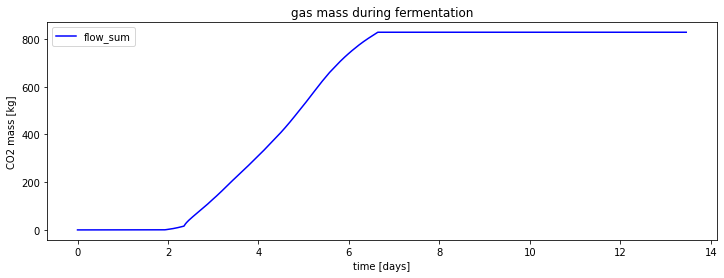

In [49]:
plt.figure(figsize=(12,4))
plt.title('gas mass during fermentation')
plt.plot(time_days, flow_mass_sum, color="blue", label="flow_sum")
plt.xlabel('time [days]')
plt.ylabel('CO2 mass [kg]')
plt.legend()
plt.show()

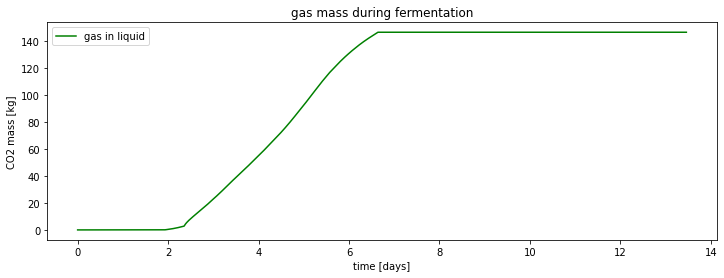

In [50]:
plt.figure(figsize=(12,4))
plt.title('gas mass during fermentation')
plt.plot(time_days, gas_in_liquid_mass, color="green", label="gas in liquid")
plt.xlabel('time [days]')
plt.ylabel('CO2 mass [kg]')
plt.legend()
plt.show()

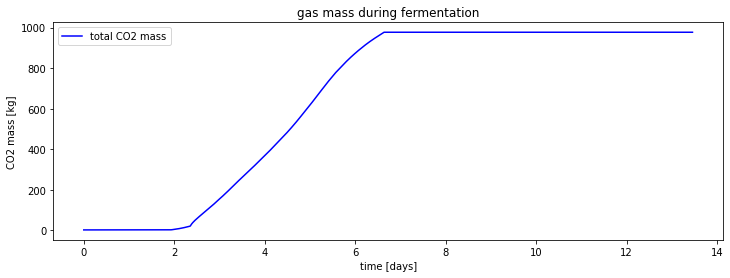

In [51]:
plt.figure(figsize=(12,4))
plt.title('gas mass during fermentation')
plt.plot(time_days, total_co2_mass, color="blue", label="total CO2 mass")
plt.xlabel('time [days]')
plt.ylabel('CO2 mass [kg]')
plt.legend()
plt.show()

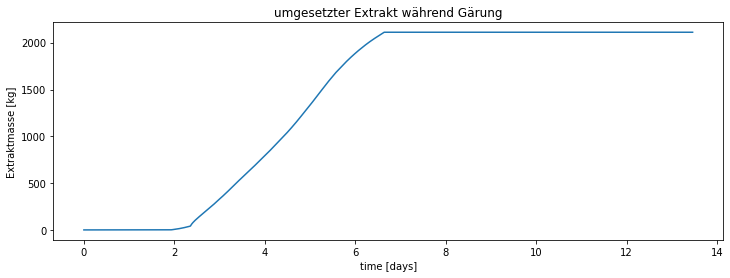

In [52]:
plt.figure(figsize=(12,4))
plt.title('umgesetzter Extrakt während Gärung')
plt.plot(time_days, extract_mass_converted)
plt.xlabel('time [days]')
plt.ylabel('Extraktmasse [kg]')
plt.show()

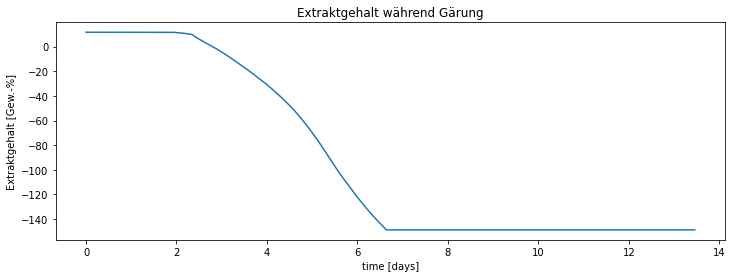

In [53]:
plt.figure(figsize=(12,4))
plt.title('Extraktgehalt während Gärung')
plt.plot(time_days, extraktgehalt)
plt.xlabel('time [days]')
plt.ylabel('Extraktgehalt [Gew.-%]')
plt.show()

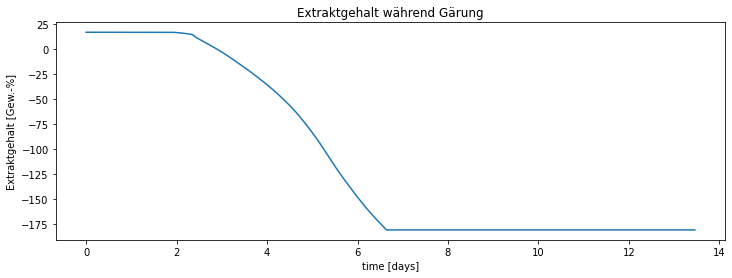

In [54]:
plt.figure(figsize=(12,4))
plt.title('Extraktgehalt während Gärung')
plt.plot(time_days, extraktgehalt_scheinbar)
plt.xlabel('time [days]')
plt.ylabel('Extraktgehalt [Gew.-%]')
plt.show()